In [30]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import nltk
import re

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nihalsrinivasu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nihalsrinivasu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
trainDF = pd.read_csv('./preprocessed_train.csv', on_bad_lines = 'skip')
trainDF.head()


,text,label,preprocessed_text
0,Do you want to hear a story? So I was at work ...,0,want hear stori work caus scientist friend ar...
1,The author does a really good job with explain...,0,author realli good job explain great detail tz...
2,I think that you guys should all become a Seag...,0,think guy becom seago cowboy adventur world ri...
3,Why should the people Of the United States vot...,0,peopl unit state vote elector vote jolt one co...
4,"Senator, I believe that voting for the Preside...",0,senat believ vote presid unit state base popu...


In [32]:

testDF = pd.read_csv('./preprocessed_test.csv', on_bad_lines = 'skip')
testDF.head()

,text,label,preprocessed_text
0,The Face on Mars is nothing but a natural occu...,0,face mar noth natur occurr mar thing call ba...
1,Students have a higher chance of catching a vi...,0,student higher chanc catch viru school hour v...
2,Driverless cars have good and bad things that ...,0,driverless car good bad thing would go along ...
3,Some people might think that traveling in a gr...,1,peopl might think travel group led tour guid g...
4,How many of us students want to be forced to d...,0,mani us student want forc someth probabl mani...


In [33]:
def generateCVEmbeddings(corpus, max_features):
  vectorizer = CountVectorizer()
  model = vectorizer.fit_transform(corpus)

  # We use the inverse_transform which returns the
  # terms per document with nonzero entries
  inverse_model = vectorizer.inverse_transform(model)

  # Each line in the inverse model corresponds to a document
  # and contains a list of feature names (the terms).
  # As we want to rank the documents we tranform the list
  # of feature names to a number of features
  # that each document is represented by.
  inverse_model_count = list(map(lambda doc_vec: len(doc_vec), inverse_model))

  # As we are going to sort the list, we need to keep track of the
  # document id (its index in the corpus), so we create tuples with
  # the list index of each item before we sort the list.
  inverse_model_count_tuples = list(zip(range(len(inverse_model_count)),
                                        inverse_model_count))

  # Then we sort the list by the count of terms
  # in each document (the second component)
  top_documents_tuples = sorted(inverse_model_count_tuples,
                                key=lambda item: item[1],
                                reverse=True)[:max_features]

  # We are interested only in the document ids (the first tuple component)
  top_documents, _ = zip(*top_documents_tuples)

  # Having the top_documents ids we can slice the initial model
  # to keep only the documents indicated by the top_documents list
  return model[top_documents]

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_features = 2500, vocabulary = None)

preprocessed_text_list = list(trainDF['preprocessed_text'])
labelList = list(trainDF['label'])
npNanRows = list()
for i in range(len(preprocessed_text_list)):
  if preprocessed_text_list[i] is np.nan:
    npNanRows.append(i)

newPreProcessedText = list()
newLabels = list()

for i in range(len(preprocessed_text_list)):
  if not i in npNanRows:
    newPreProcessedText.append(preprocessed_text_list[i])
    newLabels.append(labelList[i])

trainDF = pd.DataFrame()
trainDF['preprocessed_text'] = newPreProcessedText
trainDF['label'] = newLabels

print(trainDF.head())

# Fit and transform the preprocessed text data
# X_train_bow = generateCVEmbeddings(trainDF['preprocessed_text'], max_features = 10000)
# X_test_bow = generateCVEmbeddings(testDF['preprocessed_text'], max_features = 10000)

X_train_bow = count_vectorizer.fit_transform(trainDF['preprocessed_text'])
X_test_bow = count_vectorizer.fit_transform(testDF['preprocessed_text'])

X_train_bow.shape

                                   preprocessed_text  label
0  want hear stori  work caus scientist friend ar...      0
1  author realli good job explain great detail tz...      0
2  think guy becom seago cowboy adventur world ri...      0
3  peopl unit state vote elector vote jolt one co...      0
4  senat  believ vote presid unit state base popu...      0


(249645, 2500)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

X_half, _, y_half, _ = train_test_split(trainDF['preprocessed_text'], trainDF['label'], test_size = 0.5, random_state = 42)
len(X_half)
X_half

125716    live world car ubiquit  necessari part live  w...
237483    would intellectu pursuit  long held signific b...
25152     agre bessi student like us alway got school ev...
188849    ludwig wittgenstein famous said   limit langua...
197657    code  dear senat  senat last name   write expr...
                                ...                        
119879    student decid work home  open comput lon class...
103694    accord thd articl  thd us do technolog road th...
131932    yearround school offer tremend benefit student...
146867    eighth grade student  believ provid exampl pow...
121958    dear senat  tie elector vote use tie offic any...
Name: preprocessed_text, Length: 124822, dtype: object

In [36]:
halfTrain = pd.DataFrame()
halfTrain['text'] = list(X_half)
halfTrain['label'] = list(y_half)

del y_half
del X_half

print(len(halfTrain))
halfTrain.head()

124822


,text,label
0,live world car ubiquit necessari part live w...,1
1,would intellectu pursuit long held signific b...,1
2,agre bessi student like us alway got school ev...,0
3,ludwig wittgenstein famous said limit langua...,1
4,code dear senat senat last name write expr...,1


In [37]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_features = 2500, vocabulary = None)

# Fit and transform the preprocessed text data
X_train_bow = count_vectorizer.fit_transform(halfTrain['text'])
X_test_bow = count_vectorizer.transform(testDF['preprocessed_text'])

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features = 2500, vocabulary = None)

# Fit and transform the preprocessed text data
X_train_tfidf = tfidf_vectorizer.fit_transform(halfTrain['text'])
X_test_tfidf = tfidf_vectorizer.transform(testDF['preprocessed_text'])

In [39]:
y_train = halfTrain["label"]
y_test = testDF["label"]

In [40]:
from sklearn.model_selection import cross_val_score



# Initialize Logistic Regression model with adjusted parameters
logistic_regression_model = LogisticRegression(max_iter=10000, solver='sag')

# Perform k-fold cross-validation
scores_lr_bow = cross_val_score(logistic_regression_model, X_train_bow, y_train, cv=5)


In [41]:
print("Mean Cross-Validation Score:", scores_lr_bow.mean())
print("Standard Deviation of Cross-Validation Scores:", scores_lr_bow.std())


Mean Cross-Validation Score: 0.991892462939543
Standard Deviation of Cross-Validation Scores: 0.0006171313844928356


In [42]:
from sklearn.model_selection import cross_val_score



# Initialize Logistic Regression model with adjusted parameters
logistic_regression_model_tfidf = LogisticRegression(max_iter=10000, solver='sag')

# Perform k-fold cross-validation
scores_lr_bow_tfidf = cross_val_score(logistic_regression_model_tfidf, X_train_tfidf, y_train, cv=5)

In [43]:
print("Mean Cross-Validation Score:", scores_lr_bow.mean())
print("Standard Deviation of Cross-Validation Scores:", scores_lr_bow.std())


Mean Cross-Validation Score: 0.991892462939543
Standard Deviation of Cross-Validation Scores: 0.0006171313844928356


In [44]:
# Initialize CountVectorizer
count_vectorizer_test = CountVectorizer(max_features=2500, vocabulary=None)

# Preprocess the text
sentence = """Artificial intelligence (AI) represents the pinnacle of human innovation, offering unprecedented opportunities to
revolutionize various aspects of our lives. Through advanced algorithms and machine learning techniques,
AI systems can analyze vast amounts of data, uncover patterns, and make informed predictions,
 leading to enhanced decision-making and problem-solving capabilities. As AI continues to evolve,
  its potential to drive innovation across industries, from healthcare to finance, is boundless,
   shaping a future where intelligent machines work alongside humans to create a more efficient, sustainable, and interconnected world"""

preprocessed_sentence = sentence  # Assuming preprocess_text function is defined elsewhere

# Convert the preprocessed text into a count matrix
sentence_vector = count_vectorizer.transform([preprocessed_sentence])

# Print the count matrix
print(sentence_vector)

# Fit the logistic regression model with training data
logistic_regression_model.fit(X_train_bow, y_train)



# Use the trained logistic regression model to predict class probabilities
probabilities = logistic_regression_model.predict_proba(sentence_vector)

# Print the predicted probabilities
print("Probabilities for each class:", probabilities)

  (0, 66)	1
  (0, 105)	3
  (0, 589)	1
  (0, 701)	1
  (0, 1114)	1
  (0, 1351)	1
  (0, 1717)	1
  (0, 2361)	1
  (0, 2457)	1
  (0, 2462)	1
Probabilities for each class: [[0.44213663 0.55786337]]


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Compute predictions for the test set using the trained model
y_pred_lr_bow = probabilities = logistic_regression_model.predict(X_test_bow)

# Compute accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr_bow)

# Compute precision
precision_lr = precision_score(y_test, y_pred_lr_bow)

# Compute recall
recall_lr = recall_score(y_test, y_pred_lr_bow)

# Compute F1 score
f1_lr = f1_score(y_test, y_pred_lr_bow)


# Compute confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr_bow)

print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)
print("Confusion Matrix:\n", conf_matrix_lr)


Accuracy: 0.9837158002933466
Precision: 0.973463326446281
Recall: 0.9808730726693123
F1 Score: 0.9771541527593247
Confusion Matrix:
 [[55023   822]
 [  588 30154]]


In [46]:
logistic_regression_model_tfidf.fit(X_train_tfidf, y_train)

# Compute predictions for the test set using the trained model
y_pred_lr_tfidf = logistic_regression_model_tfidf.predict(X_test_tfidf)

# Compute accuracy
accuracy_rf_tfidf = accuracy_score(y_test, y_pred_lr_tfidf)

# Compute precision
precision_rf_tfidf = precision_score(y_test, y_pred_lr_tfidf)

# Compute recall
recall_rf_tfidf = recall_score(y_test, y_pred_lr_tfidf)

# Compute F1 score
f1_rf_tfidf = f1_score(y_test, y_pred_lr_tfidf)

# Compute confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_lr_tfidf)

print("Accuracy:", accuracy_rf_tfidf)
print("Precision:", precision_rf_tfidf)
print("Recall:", recall_rf_tfidf)
print("F1 Score:", f1_rf_tfidf)
print("Confusion Matrix:\n", conf_matrix_rf)


Accuracy: 0.9852518276415628
Precision: 0.9766102681893177
Recall: 0.9819790514605425
F1 Score: 0.9792873015100644
Confusion Matrix:
 [[55122   723]
 [  554 30188]]


In [47]:
from joblib import dump

# Specify the file path where you want to save the model
model_file_path = "./logistic_regression_model.joblib"

# Save the trained logistic regression model to a file
dump(logistic_regression_model, model_file_path)

['./logistic_regression_model.joblib']

In [48]:
# Random Forest classifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Initialize Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest model with the training data
random_forest_model.fit(X_train_bow, y_train)

# Compute predictions for the test set using the trained model
y_pred_rf_bow = random_forest_model.predict(X_test_bow)

# Compute accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf_bow)

# Compute precision
precision_rf = precision_score(y_test, y_pred_rf_bow)

# Compute recall
recall_rf = recall_score(y_test, y_pred_rf_bow)

# Compute F1 score
f1_rf = f1_score(y_test, y_pred_rf_bow)


# Compute confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf_bow)

# Print all metrics
print("Random Forest Model Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)


Random Forest Model Metrics:
Accuracy: 0.9833231316479379
Precision: 0.9862577175861382
Recall: 0.9664953483833192
F1 Score: 0.9762765328251298
Confusion Matrix:
[[55431   414]
 [ 1030 29712]]


In [49]:
from sklearn.metrics import confusion_matrix

# Initialize Random Forest model
random_forest_model_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest model with the training data
random_forest_model_tfidf.fit(X_train_tfidf, y_train)

# Compute predictions for the test set using the trained model
y_pred_rf_tfidf = random_forest_model_tfidf.predict(X_test_tfidf)

# Compute accuracy
accuracy_rf_tfidf = accuracy_score(y_test, y_pred_rf_tfidf)

# Compute precision
precision_rf_tfidf = precision_score(y_test, y_pred_rf_tfidf)

# Compute recall
recall_rf_tfidf = recall_score(y_test, y_pred_rf_tfidf)

# Compute F1 score
f1_rf_tfidf = f1_score(y_test, y_pred_rf_tfidf)

# Compute confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf_tfidf)


In [50]:
# Print all metrics
print("Random Forest Model Metrics Count Vectorizer:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)

Random Forest Model Metrics Count Vectorizer:
Accuracy: 0.9833231316479379
Precision: 0.9862577175861382
Recall: 0.9664953483833192
F1 Score: 0.9762765328251298
Confusion Matrix:
[[55292   553]
 [  957 29785]]


In [51]:
# Print all metrics
print("Random Forest Model Metrics Tfidf:")
print("Accuracy:", accuracy_rf_tfidf)
print("Precision:", precision_rf_tfidf)
print("Recall:", recall_rf_tfidf)
print("F1 Score:", f1_rf_tfidf)
print("Confusion Matrix:")
print(conf_matrix_rf)


Random Forest Model Metrics Tfidf:
Accuracy: 0.9825608925127328
Precision: 0.9817720350715274
Recall: 0.9688699499056665
F1 Score: 0.9752783235101506
Confusion Matrix:
[[55292   553]
 [  957 29785]]


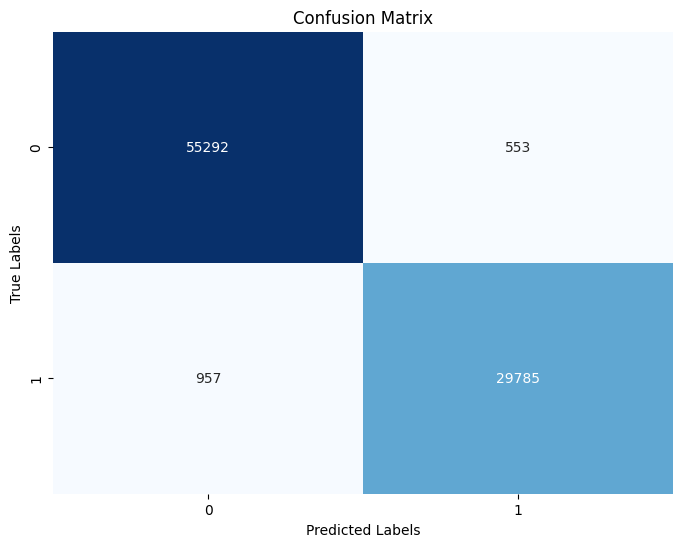

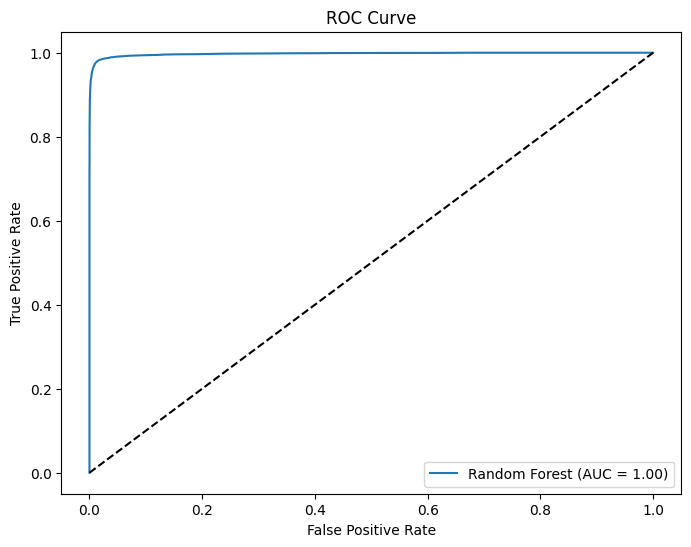

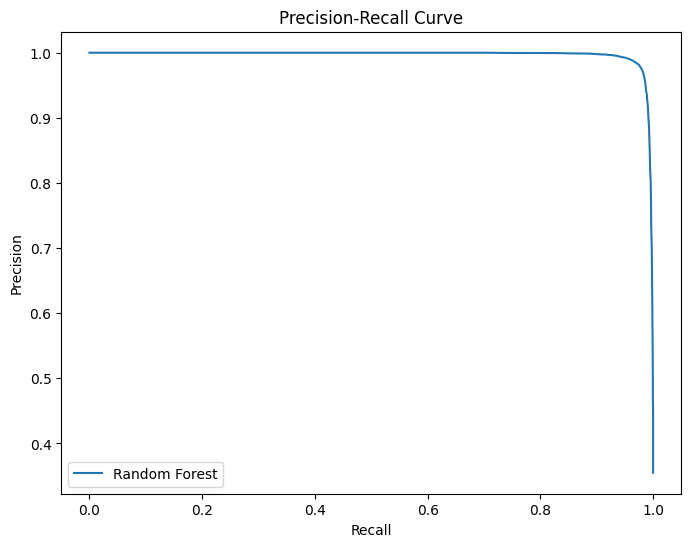

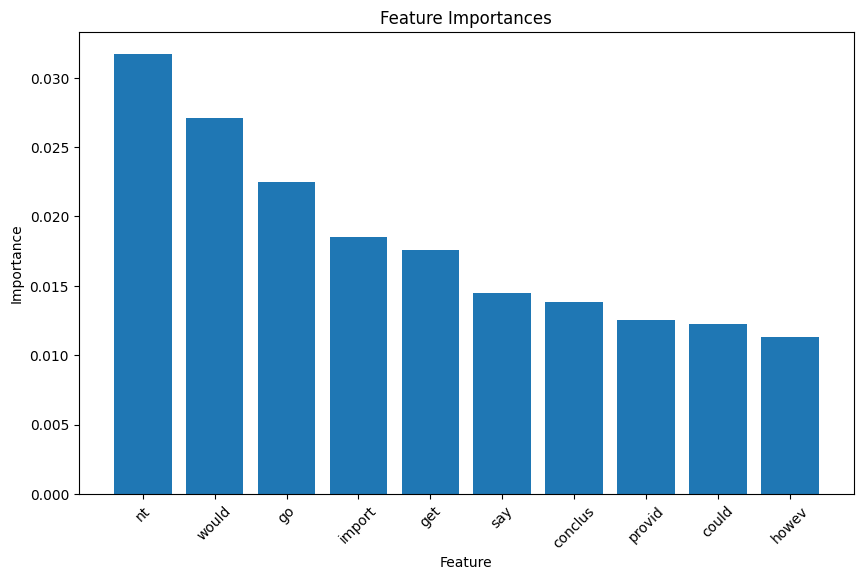

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

# Compute probabilities for the positive class
probs_rf = random_forest_model.predict_proba(X_test_bow)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, probs_rf)
auc_rf = roc_auc_score(y_test, probs_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, probs_rf)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Plot Feature Importances
feature_importances = random_forest_model.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]  # Sort indices in descending order

top_features = 10  # Plotting top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(top_features), feature_importances[sorted_indices[:top_features]])
plt.xticks(range(top_features), count_vectorizer.get_feature_names_out()[sorted_indices[:top_features]], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()
